In [2]:
import pandas as pd
import numpy as np
import math

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
#import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.svm import SVC

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as py
import plotly.express as px
import stumpy

In [3]:
conda install -c conda-forge xgboost

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install xgboost

In [5]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


## Reading the Data

In [6]:
df_train = pd.read_csv('liverpool-ion-switching/train.csv')

In [7]:
df_test = pd.read_csv('liverpool-ion-switching/test.csv')

## Exploring the Data

In [8]:
df_train.head(20)
df_train.shape

(5000000, 3)

In [9]:
df_train.tail(10)

time  signal  open_channels
4999990  499.9991  4.5083              8
4999991  499.9992  3.3877              7
4999992  499.9993  2.3484              7
4999993  499.9994  4.1915              8
4999994  499.9995  4.3713              8
4999995  499.9996  2.9194              7
4999996  499.9997  2.6980              7
4999997  499.9998  4.5164              8
4999998  499.9999  5.6397              9
4999999  500.0000  5.3792              9

In [10]:
df_test.head()

time  signal
0  500.0001 -2.6498
1  500.0002 -2.8494
2  500.0003 -2.8600
3  500.0004 -2.4350
4  500.0005 -2.6155

In [11]:
df_samp = pd.read_csv('liverpool-ion-switching/sample_submission.csv')

In [12]:
df_samp.tail()

time  open_channels
1999995  699.9996              0
1999996  699.9997              0
1999997  699.9998              0
1999998  699.9999              0
1999999  700.0000              0

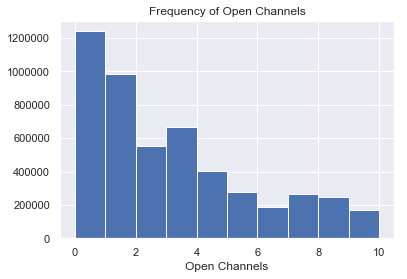

In [13]:
plt.hist(df_train['open_channels'])
plt.xlabel('Open Channels')
plt.title('Frequency of Open Channels')
plt.show()

## "Batching" the Data
Since this data is taken in 50 second increments, there are discontinuties among the data. 

In [14]:
df_train['batch'] = (df_train.index // 500_000) + 1

In [15]:
df_train = df_train.assign(outcome_open_channel=(df_train['open_channels']>0).astype(int))

In [16]:
df_train.head()

time  signal  open_channels  batch  outcome_open_channel
0  0.0001 -2.7600              0      1                     0
1  0.0002 -2.8557              0      1                     0
2  0.0003 -2.4074              0      1                     0
3  0.0004 -3.1404              0      1                     0
4  0.0005 -3.1525              0      1                     0

In [17]:
df_test.shape

(2000000, 2)

In [18]:
df_train.groupby('batch')[['signal','open_channels']].agg(['min', 'max', 'median'])

signal                  open_channels           
          min      max  median           min max median
batch                                                  
1     -3.8506   4.9998 -2.7098             0   1      0
2     -3.9021   2.2236 -2.6476             0   1      0
3     -3.9107  -0.3525 -1.6101             0   1      1
4     -3.7073   2.2404 -0.1340             0   3      2
5     -5.7965   8.6131  3.3926             0  10      7
6     -3.8174   4.7929  1.9179             0   5      4
7     -3.5033   4.4771  1.6736             0   1      1
8     -3.4952   9.9998  3.2293             0   3      2
9     -3.2033   9.4897  4.9765             0   5      4
10    -3.9085  13.2440  6.5999             1  10      7

In [19]:
df_train.groupby('open_channels')[['signal','batch']].agg(['min', 'max', 'median'])

signal                  batch           
                  min      max  median   min max median
open_channels                                          
0             -5.7965   9.9528 -2.6595     1   9      2
1             -5.3438   9.9987 -1.1250     1  10      4
2             -4.6254   9.9998  0.1494     4  10      8
3             -3.1726   9.9998  1.3862     4  10      6
4             -2.1492   8.3958  2.5951     5  10      6
5             -0.9996   9.4897  3.6542     5  10      9
6              0.1303   8.4208  2.5536     5  10     10
7              1.3480   9.6833  3.7647     5  10     10
8              2.4193  11.1990  4.9867     5  10      5
9              3.9629  12.1340  6.1871     5  10      5
10             5.3285  13.2440  7.4271     5  10      5

In [20]:
df_train.groupby(['batch','open_channels'])[['signal']].agg(['min', 'max', 'median'])

signal                   
                        min      max    median
batch open_channels                           
1     0             -3.8506   4.9998  -2.72000
      1             -2.4036  -0.4163  -1.48320
2     0             -3.9021   1.1587  -2.66310
      1             -2.4582   2.2236  -1.36830
3     0             -3.9107  -1.4957  -2.73650
      1             -2.7586  -0.3525  -1.50150
4     0             -3.7073  -1.7493  -2.73990
      1             -2.7763  -0.3116  -1.50500
      2             -1.5271   0.9555  -0.27510
      3             -0.2341   2.2404   0.95690
5     0             -5.7965  -5.7481  -5.77230
      1             -5.3438  -3.3162  -4.32820
      2             -4.6254  -1.6356  -2.99355
      3             -3.1726  -0.3517  -1.76550
      4             -2.1492   0.9949  -0.52700
      5             -0.9996   2.4400   0.71300
      6              0.1303   3.7926   1.94030
      7              1.3480   4.9947   3.17640
      8              2.4193   6.0338   4.41070
      9              3.9629   7.1794   5.64270
      10             5.3285   8.6131   6.87675
6     0             -3.8174  -1.7285  -2.72505
      1             -2.8902  -0.3566  -1.49810
      2             -1.5576   0.9042  -0.26460
      3             -0.2754   2.2316   0.96830
      4              0.9769   3.4705   2.20380
      5              2.1698   4.7929   3.43810
7     0             -3.5033   3.2060   0.82600
      1             -2.3241   4.4771   2.01670
8     0             -3.4952   9.9528   0.55645
      1             -2.8414   9.9987   1.87030
      2             -1.2088   9.9998   3.17600
      3             -1.0893   9.9998   4.44190
9     0             -3.2033   2.9513   0.55170
      1             -2.2494   4.3286   2.07310
      2             -1.0989   5.8212   3.30560
      3              0.1085   7.0330   4.49965
      4              1.1508   8.3958   5.67385
      5              2.6939   9.4897   6.91750
10    1             -3.9085   1.4398  -0.40390
      2             -3.4849   2.9519   0.70490
      3             -2.5633   4.3780   1.83780
      4             -1.7234   6.0027   3.00690
      5             -0.4914   7.2001   4.19065
      6              0.7574   8.4208   5.40020
      7              1.6189   9.6833   6.65655
      8              2.9139  11.1990   7.93505
      9              4.1721  12.1340   9.21400
      10             5.4508  13.2440  10.46200

In [21]:
df_train.describe()

time        signal  open_channels         batch  \
count  5.000000e+06  5.000000e+06   5.000000e+06  5.000000e+06   
mean   2.500001e+02  1.386246e+00   2.726043e+00  5.500000e+00   
std    1.443376e+02  3.336219e+00   2.665051e+00  2.872282e+00   
min    1.000000e-04 -5.796500e+00   0.000000e+00  1.000000e+00   
25%    1.250001e+02 -1.594800e+00   1.000000e+00  3.000000e+00   
50%    2.500000e+02  1.124000e+00   2.000000e+00  5.500000e+00   
75%    3.750000e+02  3.690100e+00   4.000000e+00  8.000000e+00   
max    5.000000e+02  1.324400e+01   1.000000e+01  1.000000e+01   

       outcome_open_channel  
count          5.000000e+06  
mean           7.519696e-01  
std            4.318696e-01  
min            0.000000e+00  
25%            1.000000e+00  
50%            1.000000e+00  
75%            1.000000e+00  
max            1.000000e+00

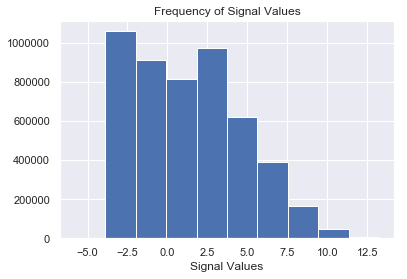

In [22]:
plt.hist(df_train['signal'])
plt.xlabel('Signal Values')
plt.title('Frequency of Signal Values')
plt.show()

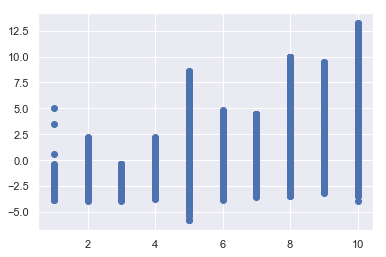

In [23]:
x = df_train['batch']
y = df_train['signal']
plt.scatter(x,y)
plt.show()

### The graph below shows the noise in each batch of data. The parabolic noise was added to the data. 

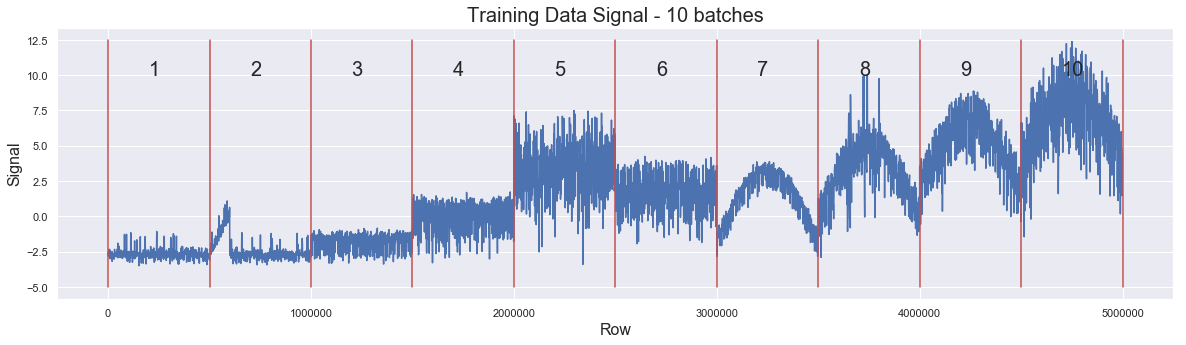

In [24]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,df_train.shape[0],res),df_train.signal[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

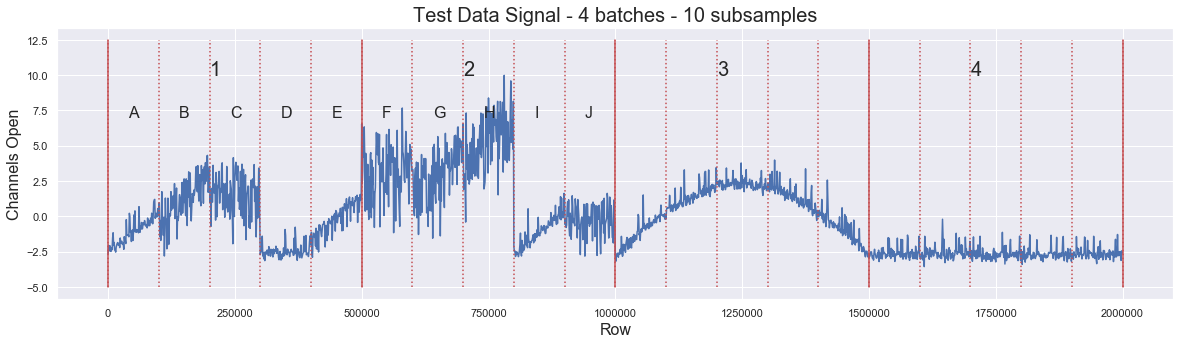

In [25]:
plt.figure(figsize=(20,5))
res = 1000; let = ['A','B','C','D','E','F','G','H','I','J']
plt.plot(range(0,df_test.shape[0],res),df_test.signal[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(21): plt.plot([j*100000,j*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+200000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7,let[k],size=16)
plt.xlabel('Row',size=16); plt.ylabel('Channels Open',size=16); 
plt.title('Test Data Signal - 4 batches - 10 subsamples',size=20)
plt.show()

## This heatmap shows that most of the open channels are actually closed, with most batches giving 0 open channels.

In [26]:
fig = px.density_heatmap(df_train.iloc[::50, :], x='signal', y='open_channels')
fig.show()

## Create Baseline

Using Gradient Boosted Trees model as baseline for this time series problem. Original baseline code was lost, been trying to duplicate it. First F1 score: 68%.

May 19, 2020
How to engineer these features? 

https://www.kaggle.com/cameronlai/getting-started-data-visualization-xgboost

Ideas for modeling taken from the above link.

In [27]:
#from https://www.kaggle.com/suicaokhoailang/an-embarrassingly-simple-baseline

n_groups = 40
df_train["group"] = 0
for i in range(n_groups):
    ids = np.arange(i*50000, (i+1)*50000)
    df_train.loc[ids,"group"] = i

In [28]:
# Baseline model score : 61.4%

for i in range(n_groups):
    sub = df_train[df_train.group == i]
    signals = sub.signal.values
    imax, imin = math.floor(np.max(signals)), math.ceil(np.min(signals))
    signals = (signals - np.min(signals))/(np.max(signals) - np.min(signals))
    signals = signals*(imax-imin)
    df_train.loc[sub.index,"open_channels"] = np.array(signals,np.int)


signal_avg = signals.mean()/(imax-imin)
print(signal_avg)   
#df2 =  np.array(df_train.open_channels, np.int)
#print(df2)

0.6138388274132736


## Cleaning training and test data.

In [29]:
df_train2 = df_train.copy()

In [30]:
df_train2.open_channels = np.array(df_train.open_channels, np.int)

In [31]:
df_train2.tail()

time  signal  open_channels  batch  outcome_open_channel  group
4999995  499.9996  2.9194              8     10                     1      0
4999996  499.9997  2.6980              8     10                     1      0
4999997  499.9998  4.5164              9     10                     1      0
4999998  499.9999  5.6397             10     10                     1      0
4999999  500.0000  5.3792             10     10                     1      0

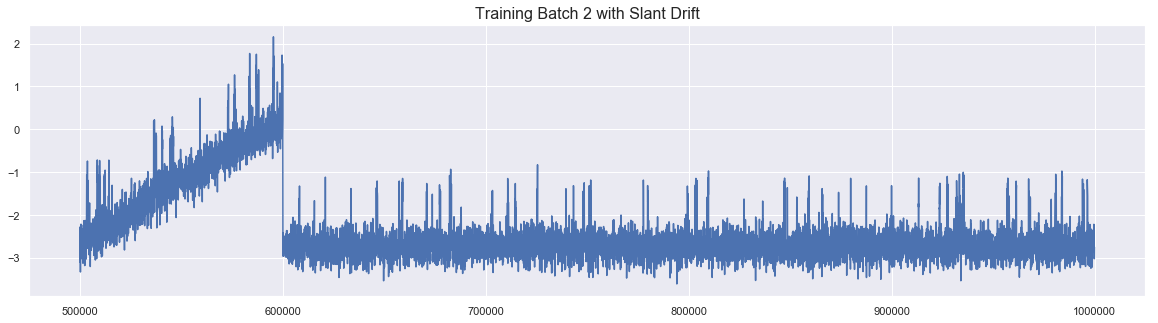

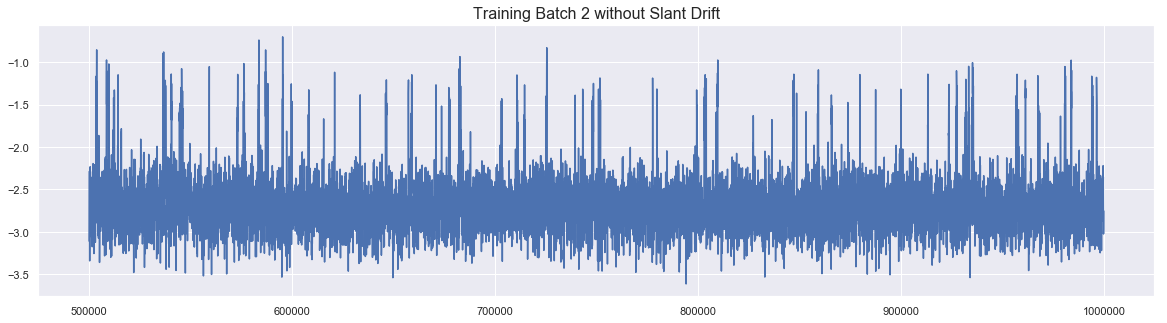

In [32]:


a=500000; b=600000 # CLEAN TRAIN BATCH 2

df_train2.loc[df_train.index[a:b],'signal'] = df_train2.signal[a:b].values - 3*(df_train2.time.values[a:b] - 50)/10.
batch=2; a=500000*(batch-1); b=500000*batch; res=50
plt.figure(figsize=(20,5))
plt.plot(range(a,b,res),df_train.signal[a:b][0::res])
plt.title('Training Batch 2 with Slant Drift',size=16)
plt.figure(figsize=(20,5))
plt.plot(range(a,b,res),df_train2.signal[a:b][0::res])
plt.title('Training Batch 2 without Slant Drift',size=16)
plt.show()


In [33]:
df_train2.head()

time  signal  open_channels  batch  outcome_open_channel  group
0  0.0001 -2.7600              2      1                     0      0
1  0.0002 -2.8557              2      1                     0      0
2  0.0003 -2.4074              3      1                     0      0
3  0.0004 -3.1404              2      1                     0      0
4  0.0005 -3.1525              2      1                     0      0

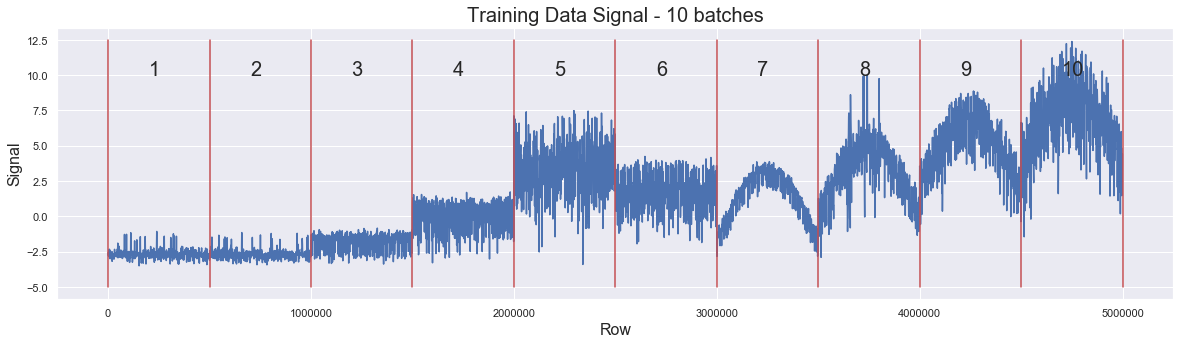

In [34]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,df_train2.shape[0],res),df_train2.signal[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

In [35]:
#def f(x,low,high,mid): return -((-low+high)/625)*(x-mid)**2+high -low


batch=3; a=500000*(batch-1); b=500000*batch; res=50
df_train2.loc[df_train.index[a:b],'signal'] = df_train2.signal[a:b].values - 3*(df_train2.time.values[a:b] - 50)/10.

batch=4; a=500000*(batch-1); b=500000*batch; res=50
df_train2.loc[df_train.index[a:b],'signal'] = df_train2.signal[a:b].values - 3*(df_train2.time.values[a:b] - 50)/10.

batch=5; a=500000*(batch-1); b=500000*batch; res=50
df_train2.loc[df_train.index[a:b],'signal'] = df_train2.signal[a:b].values - 3*(df_train2.time.values[a:b] - 50)/10.

batch=6; a=500000*(batch-1); b=500000*batch; res=50
df_train2.loc[df_train.index[a:b],'signal'] = df_train2.signal[a:b].values - 3*(df_train2.time.values[a:b] - 50)/10.



In [36]:
def f(x,low,high,mid): return -((-low+high)/625)*(x-mid)**2+high -low

# CLEAN TRAIN BATCH 7
batch = 7; a = 500000*(batch-1); b = 500000*batch
df_train2.loc[df_train2.index[a:b],'signal'] = df_train.signal.values[a:b] - f(df_train.time[a:b].values,-1.817,3.186,325)
# CLEAN TRAIN BATCH 8
batch = 8; a = 500000*(batch-1); b = 500000*batch
df_train2.loc[df_train2.index[a:b],'signal'] = df_train.signal.values[a:b] - f(df_train.time[a:b].values,-0.094,4.936,375)
# CLEAN TRAIN BATCH 9
batch = 9; a = 500000*(batch-1); b = 500000*batch
df_train2.loc[df_train2.index[a:b],'signal'] = df_train.signal.values[a:b] - f(df_train.time[a:b].values,1.715,6.689,425)
# CLEAN TRAIN BATCH 10
batch = 10; a = 500000*(batch-1); b = 500000*batch
df_train2.loc[df_train2.index[a:b],'signal'] = df_train.signal.values[a:b] - f(df_train.time[a:b].values,3.361,8.45,475)

In [37]:
df_train.dropna(inplace = True)

In [38]:
df_test2 = df_test.copy()

In [39]:
n_groups = 40
df_test2["group"] = 0
for i in range(n_groups):
    ids = np.arange(i*50000, (i+1)*50000)
    df_test2.loc[ids,"group"] = i

In [40]:
# REMOVE BATCH 1 DRIFT
start=500
a = 0; b = 100000
df_test2.loc[df_test2.index[a:b],'signal'] = df_test2.signal.values[a:b] - 3*(df_test2.time.values[a:b]-start)/10.
start=510
a = 100000; b = 200000
df_test2.loc[df_test2.index[a:b],'signal'] = df_test2.signal.values[a:b] - 3*(df_test2.time.values[a:b]-start)/10.
start=540
a = 400000; b = 500000
df_test2.loc[df_test2.index[a:b],'signal'] = df_test2.signal.values[a:b] - 3*(df_test2.time.values[a:b]-start)/10.

In [41]:
# REMOVE BATCH 2 DRIFT
start=560
a = 600000; b = 700000
df_test2.loc[df_test2.index[a:b],'signal'] = df_test2.signal.values[a:b] - 3*(df_test2.time.values[a:b]-start)/10.
start=570
a = 700000; b = 800000
df_test2.loc[df_test2.index[a:b],'signal'] = df_test2.signal.values[a:b] - 3*(df_test2.time.values[a:b]-start)/10.
start=580
a = 800000; b = 900000
df_test2.loc[df_test2.index[a:b],'signal'] = df_test2.signal.values[a:b] - 3*(df_test2.time.values[a:b]-start)/10.

In [42]:
# REMOVE BATCH 3 DRIFT
def f(x):
    return -(0.00788)*(x-625)**2+2.345 +2.58
a = 1000000; b = 1500000
df_test2.loc[df_test2.index[a:b],'signal'] = df_test2.signal.values[a:b] - f(df_test2.time[a:b].values)

In [43]:
clf = GradientBoostingClassifier(n_estimators=2000,
                                 learning_rate=0.1, random_state=10, 
                                 subsample=0.9, max_depth=5, max_features=5,
                                 min_samples_leaf=2, min_samples_split=5,
                                 validation_fraction=0.20, # use 20% of the data as hold-out for early stopping
                                 n_iter_no_change=50, # allowed to go 50 iterations without improvement to hold-out score
                                 verbose=0)
used_cols = [c for c in df_train2.columns.tolist() if c not in ['open_channels']]
X_train = df_train2[used_cols]
y_train = df_train2['open_channels']

print(used_cols)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,  
 #   test_size=0.25, random_state=10)
#scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
#print(scores.mean(), "+/-", scores.std())
#f1 = f1_score(feature, y)
#f1
#clf.fit(X_train,y_train)

['time', 'signal', 'batch', 'outcome_open_channel', 'group']


In [44]:
#Attempt at an XGBoost model, first must do some feature engineering (May 19)

xb = xgb.XGBRegressor(max_depth=10)
xb.fit(X_train, y_train)
print(xb)

/Users/lenaya/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/lenaya/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[05:56:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:20] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


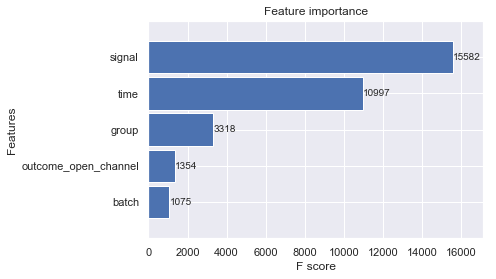

In [45]:
xgb.plot_importance(xb, height=0.9)

In [46]:
print(xb.score(X_train, y_train))

0.9839742099447701


In [47]:
df_train2.head()

time  signal  open_channels  batch  outcome_open_channel  group
0  0.0001 -2.7600              2      1                     0      0
1  0.0002 -2.8557              2      1                     0      0
2  0.0003 -2.4074              3      1                     0      0
3  0.0004 -3.1404              2      1                     0      0
4  0.0005 -3.1525              2      1                     0      0

In [48]:
df_train2.tail()

time    signal  open_channels  batch  outcome_open_channel  group
4999995  499.9996  2.919237              8     10                     1      0
4999996  499.9997  2.697878              8     10                     1      0
4999997  499.9998  4.516319              9     10                     1      0
4999998  499.9999  5.639659             10     10                     1      0
4999999  500.0000  5.379200             10     10                     1      0

In [49]:
df_train2.tail()

time    signal  open_channels  batch  outcome_open_channel  group
4999995  499.9996  2.919237              8     10                     1      0
4999996  499.9997  2.697878              8     10                     1      0
4999997  499.9998  4.516319              9     10                     1      0
4999998  499.9999  5.639659             10     10                     1      0
4999999  500.0000  5.379200             10     10                     1      0

In [50]:
#normalize the data (standard scaler). We can also try other scalers for a better score!
def normalize(train, test):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean) / train_input_sigma
    test['signal'] = (test.signal - train_input_mean) / train_input_sigma
    return train, test

# get lead and lags features
def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
    return df

# main module to run feature engineering. Here you may want to try and add other features and check if your score imporves :).
def run_feat_engineering(df):
    
    # create leads and lags (1, 2, 3 making them 6 features)
    df = lag_with_pct_change(df, [1, 2, 3])
    # create signal ** 2 (this is the new feature)
    df['signal_2'] = df['signal'] ** 2
    return df

In [51]:
normalize(df_train2,df_test2)

(             time    signal  open_channels  batch  outcome_open_channel  group
 0          0.0001  0.641274              2      1                     0      0
 1          0.0002  0.637243              2      1                     0      0
 2          0.0003  0.656127              3      1                     0      0
 3          0.0004  0.625250              2      1                     0      0
 4          0.0005  0.624741              2      1                     0      0
 ...           ...       ...            ...    ...                   ...    ...
 4999995  499.9996  0.880506              8     10                     1      0
 4999996  499.9997  0.871182              8     10                     1      0
 4999997  499.9998  0.947782              9     10                     1      0
 4999998  499.9999  0.995101             10     10                     1      0
 4999999  500.0000  0.984130             10     10                     1      0
 
 [5000000 rows x 6 columns],          

In [52]:
run_feat_engineering(df_train2)

time    signal  open_channels  batch  outcome_open_channel  \
0          0.0001  0.641274              2      1                     0   
1          0.0002  0.637243              2      1                     0   
2          0.0003  0.656127              3      1                     0   
3          0.0004  0.625250              2      1                     0   
4          0.0005  0.624741              2      1                     0   
...           ...       ...            ...    ...                   ...   
4999995  499.9996  0.880506              8     10                     1   
4999996  499.9997  0.871182              8     10                     1   
4999997  499.9998  0.947782              9     10                     1   
4999998  499.9999  0.995101             10     10                     1   
4999999  500.0000  0.984130             10     10                     1   

         group  signal_shift_pos_1  signal_shift_neg_1  signal_shift_pos_2  \
0            0            0.000000            0.637243            0.000000   
1            0            0.641274            0.656127            0.000000   
2            0            0.637243            0.625250            0.641274   
3            0            0.656127            0.624741            0.637243   
4            0            0.625250            0.646253            0.656127   
...        ...                 ...                 ...                 ...   
4999995      0            0.941665            0.871182            0.934089   
4999996      0            0.880506            0.947782            0.941665   
4999997      0            0.871182            0.995101            0.880506   
4999998      0            0.947782            0.984130            0.871182   
4999999      0            0.995101            0.000000            0.947782   

         signal_shift_neg_2  signal_shift_pos_3  signal_shift_neg_3  signal_2  
0                  0.656127            0.000000            0.625250  0.411233  
1                  0.625250            0.000000            0.624741  0.406079  
2                  0.624741            0.000000            0.646253  0.430503  
3                  0.646253            0.641274            0.643831  0.390938  
4                  0.643831            0.637243            0.648288  0.390301  
...                     ...                 ...                 ...       ...  
4999995            0.947782            0.856448            0.995101  0.775292  
4999996            0.995101            0.934089            0.984130  0.758958  
4999997            0.984130            0.941665            0.000000  0.898290  
4999998            0.000000            0.880506            0.000000  0.990227  
4999999            0.000000            0.871182            0.000000  0.968512  

[5000000 rows x 13 columns]

In [53]:
run_feat_engineering(df_test2)

time    signal  group  signal_shift_pos_1  signal_shift_neg_1  \
0        500.0001  0.645915      0            0.000000            0.637506   
1        500.0002  0.637506      0            0.645915            0.637058   
2        500.0003  0.637058      0            0.637506            0.654960   
3        500.0004  0.654960      0            0.637058            0.647355   
4        500.0005  0.647355      0            0.654960            0.649443   
...           ...       ...    ...                 ...                 ...   
1999995  699.9996  0.634989     39            0.638389            0.642024   
1999996  699.9997  0.642024     39            0.634989            0.638389   
1999997  699.9998  0.638389     39            0.642024            0.634989   
1999998  699.9999  0.634989     39            0.638389            0.642024   
1999999  700.0000  0.642024     39            0.634989            0.000000   

         signal_shift_pos_2  signal_shift_neg_2  signal_shift_pos_3  \
0                  0.000000            0.637058            0.000000   
1                  0.000000            0.654960            0.000000   
2                  0.645915            0.647355            0.000000   
3                  0.637506            0.649443            0.645915   
4                  0.637058            0.642201            0.637506   
...                     ...                 ...                 ...   
1999995            0.642239            0.638389            0.640465   
1999996            0.638389            0.634989            0.642239   
1999997            0.634989            0.642024            0.638389   
1999998            0.642024            0.000000            0.634989   
1999999            0.638389            0.000000            0.642024   

         signal_shift_neg_3  signal_2  
0                  0.654960  0.417206  
1                  0.647355  0.406414  
2                  0.649443  0.405843  
3                  0.642201  0.428972  
4                  0.640472  0.419068  
...                     ...       ...  
1999995            0.634989  0.403212  
1999996            0.642024  0.412195  
1999997            0.000000  0.407540  
1999998            0.000000  0.403212  
1999999            0.000000  0.412195  

[2000000 rows x 10 columns]

In [54]:
X_train = df_train2[used_cols]
y_train = df_train2['open_channels']
print(xb.score(X_train, y_train))  ## Not the F1 score needed, but this accuracy score of 63.4% was used in the capstone presentation. 

0.6347168273053052


In [59]:
df_test2.head()

time    signal  group  signal_shift_pos_1  signal_shift_neg_1  \
0  500.0001  0.645915      0            0.000000            0.637506   
1  500.0002  0.637506      0            0.645915            0.637058   
2  500.0003  0.637058      0            0.637506            0.654960   
3  500.0004  0.654960      0            0.637058            0.647355   
4  500.0005  0.647355      0            0.654960            0.649443   

   signal_shift_pos_2  signal_shift_neg_2  signal_shift_pos_3  \
0            0.000000            0.637058            0.000000   
1            0.000000            0.654960            0.000000   
2            0.645915            0.647355            0.000000   
3            0.637506            0.649443            0.645915   
4            0.637058            0.642201            0.637506   

   signal_shift_neg_3  signal_2  
0            0.654960  0.417206  
1            0.647355  0.406414  
2            0.649443  0.405843  
3            0.642201  0.428972  
4            0.640472  0.419068

##### Had trouble running the next three cells. The Jupyter Notebook kept crashing and I wasn't able to get the results I needed. 

In [ ]:

xb.fit(X_train, y_train)

[06:59:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:59:17] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [ ]:
#used_cols = [c for c in df_test2.columns.tolist() if c not in ['open_channels']]
X_t = df_train2['signal']
y_t = df_train2['open_channels']
xgb_predict=xb.predict(X_t)
xgb_predict

In [ ]:
print(confusion_matrix(y_t,xgb_predict))
print(confusion_matrix(y_t,xgb_predict))

### This is an attempt to create separate dataframes for each batch, which then can be used the its matrix profile using Stumpy; however, even after splitting the data up by batch, the data was still too large.  Working with Stumpy would require more time than I planned. So this was scrapped from the final project results. 

In [ ]:
batch_2 = df_train2.loc[(df_train2.batch == 2) ]
#batch_1

In [ ]:
#m_ = 50
#mp = stumpy.stump(batch_1['signal'], m=m_)

In [ ]:
#plt.suptitle('test STUMP', fontsize='30')
#plt.xlabel('Window Start', fontsize ='20')
#plt.ylabel('Matrix Profile', fontsize='20')
#plt.plot(mp[:, 0])
#plt.show()

## References

* https://www.kaggle.com/cdeotte/one-feature-model-0-930
* https://www.kaggle.com/vbmokin/ion-switching-advfe-lgb-wavenet-confmatrix
* https://www.kaggle.com/teejmahal20/single-model-lgbm-kalman-filter
* https://www.kaggle.com/suicaokhoailang/an-embarrassingly-simple-baseline
* https://www.kaggle.com/teejmahal20/3-simple-ideas-ensemble
* https://www.kaggle.com/furiousx7/xgboost-time-series
* https://www.kaggle.com/mobassir/understanding-ion-switching-with-modeling?scriptVersionId=32647837
* https://neurosciencenews.com/vrac-ion-channel-virus-16144/
* https://www.nature.com/articles/s42003-019-0729-3.pdf
* https://towardsdatascience.com/using-gradient-boosting-for-time-series-prediction-tasks-600fac66a5fc
